python implementation


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import pandas as pd
import json
from sklearn.metrics import confusion_matrix

# Disable eager execution for TF 2.x compatibility with TF 1.x code
tf.compat.v1.disable_eager_execution()

# Load MNIST dataset
mnist_data = tfds.load("mnist", as_supervised=True)
train_data, test_data = mnist_data["train"], mnist_data["test"]

Load & Preprocess MNIST Dataset

In [ ]:
# Preprocess function: Flatten and Normalize
def preprocess(image, label):
    image = tf.reshape(image, [-1])  # Flatten (28x28 → 784)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize (0-255 → 0-1)
    label = tf.one_hot(label, depth=10)  # One-hot encode
    return image, label

# Training parameters
batch_size = 10
num_epochs = 50
steps_per_epoch = 60000 // batch_size  # MNIST has 60,000 training images

# Apply preprocessing, shuffle, and batch
train_data = train_data.map(preprocess).shuffle(10000).batch(batch_size)
test_data = test_data.map(preprocess).batch(batch_size)

# Define placeholders
X = tf.compat.v1.placeholder(tf.float32, shape=[None, 784])
Y = tf.compat.v1.placeholder(tf.float32, shape=[None, 10])

In [4]:

# Store results
results = []
time_records = []
accuracy_curves = {}
loss_curves = {}
confusion_matrices = {}

hidden_layer_configs = [(160, 100), (100, 100), (100, 160)]
learning_rates = [0.01, 0.1, 1]

In [ ]:

# Define network parameters
def create_network(h1, h2):
    weights = {
        "h1": tf.Variable(tf.random.normal([784, h1])),
        "h2": tf.Variable(tf.random.normal([h1, h2])),
        "out": tf.Variable(tf.random.normal([h2, 10])),
    }
    biases = {
        "b1": tf.Variable(tf.random.normal([h1])),
        "b2": tf.Variable(tf.random.normal([h2])),
        "out": tf.Variable(tf.random.normal([10])),
    }
    return weights, biases
     

In [8]:
# Define network parameters
def create_network(h1, h2):
    weights = {
        "h1": tf.Variable(tf.random.normal([784, h1])),
        "h2": tf.Variable(tf.random.normal([h1, h2])),
        "out": tf.Variable(tf.random.normal([h2, 10])),
    }
    biases = {
        "b1": tf.Variable(tf.random.normal([h1])),
        "b2": tf.Variable(tf.random.normal([h2])),
        "out": tf.Variable(tf.random.normal([10])),
    }
    return weights, biases
     

In [9]:

# Define forward propagation function
def forward_propagation(x, weights, biases):
    layer1 = tf.nn.relu(tf.add(tf.matmul(x, weights["h1"]), biases["b1"]))
    layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, weights["h2"]), biases["b2"]))
    output_layer = tf.add(tf.matmul(layer2, weights["out"]), biases["out"])
    return output_layer

In [ ]:
We would be training 9 configs:
    
hidden_layer_configs = [(160, 100), (100, 100), (100, 160)]
learning_rates = [0.01, 0.1, 1]

In [10]:
import os
import numpy as np
import json

save_dir = r"C:\Users\Owner\Downloads\codes\ml\dl\exp 4"

In [11]:
with tf.compat.v1.Session() as sess:
    for h1, h2 in hidden_layer_configs:
        for lr in learning_rates:
            print(f"Training with hidden layers ({h1}, {h2}) and learning rate {lr}")
            start_time = time.time()

            # Create network
            weights, biases = create_network(h1, h2)
            logits = forward_propagation(X, weights, biases)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
            optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr).minimize(loss)
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            sess.run(tf.compat.v1.global_variables_initializer())
            iterator = tf.compat.v1.data.make_initializable_iterator(train_data)
            next_batch = iterator.get_next()

            accuracy_list = []
            loss_list = []

            for epoch in range(num_epochs):
                sess.run(iterator.initializer)
                avg_loss = 0
                avg_accuracy = 0

                for _ in range(steps_per_epoch):
                    try:
                        batch_x, batch_y = sess.run(next_batch)
                        _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
                        avg_loss += l / steps_per_epoch
                        avg_accuracy += acc / steps_per_epoch
                    except tf.errors.OutOfRangeError:
                        sess.run(iterator.initializer)

                accuracy_list.append(avg_accuracy)
                loss_list.append(avg_loss)
                print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy*100:.2f}%")
            print(f"Final Training Accuracy for hidden layers ({h1}, {h2}) and learning rate {lr} : {avg_accuracy*100:.2f}%")

            accuracy_curves[(h1, h2, lr)] = accuracy_list
            loss_curves[(h1, h2, lr)] = loss_list

            iterator_test = tf.compat.v1.data.make_initializable_iterator(test_data)
            next_test_batch = iterator_test.get_next()
            test_accuracy = 0
            test_steps = 10000 // batch_size
            sess.run(iterator_test.initializer)
            y_true, y_pred = [], []

            for _ in range(test_steps):
                batch_x, batch_y = sess.run(next_test_batch)
                acc, preds = sess.run([accuracy, tf.argmax(logits, 1)], feed_dict={X: batch_x, Y: batch_y})
                test_accuracy += acc / test_steps
                y_true.extend(np.argmax(batch_y, axis=1))
                y_pred.extend(preds)

            confusion_matrices[(h1, h2, lr)] = confusion_matrix(y_true, y_pred)
            results.append(((h1, h2), lr, test_accuracy * 100, time.time() - start_time))
            
            os.makedirs(save_dir, exist_ok=True)

            # Save results after each configuration
            np.save(os.path.join(save_dir, "accuracy_curves_final1.npy"), accuracy_curves)
            np.save(os.path.join(save_dir, "loss_curves_final1.npy"), loss_curves)
            np.save(os.path.join(save_dir, "confusion_matrices_final1.npy"), confusion_matrices)

            # Save results as JSON
            with open(os.path.join(save_dir, "results_final1.json"), "w") as f:
                json.dump([[tuple(elem[0]), float(elem[1]), float(elem[2]), float(elem[3])] for elem in results], f)

Training with hidden layers (160, 100) and learning rate 0.01



Epoch 1, Loss: 6.8536, Accuracy: 69.49%
Epoch 2, Loss: 0.7061, Accuracy: 82.26%
Epoch 3, Loss: 0.5487, Accuracy: 87.56%
Epoch 4, Loss: 0.4657, Accuracy: 90.39%
Epoch 5, Loss: 0.4512, Accuracy: 91.14%
Epoch 6, Loss: 0.4386, Accuracy: 91.23%
Epoch 7, Loss: 0.4241, Accuracy: 91.53%
Epoch 8, Loss: 0.4154, Accuracy: 91.43%
Epoch 9, Loss: 0.4148, Accuracy: 92.24%
Epoch 10, Loss: 0.4024, Accuracy: 92.13%
Epoch 11, Loss: 0.4479, Accuracy: 91.61%
Epoch 12, Loss: 0.4147, Accuracy: 91.88%
Epoch 13, Loss: 0.3756, Accuracy: 92.65%
Epoch 14, Loss: 0.4208, Accuracy: 92.02%
Epoch 15, Loss: 0.4451, Accuracy: 90.94%
Epoch 16, Loss: 0.4358, Accuracy: 91.37%
Epoch 17, Loss: 0.4202, Accuracy: 91.32%
Epoch 18, Loss: 0.4426, Accuracy: 91.06%
Epoch 19, Loss: 0.4339, Accuracy: 91.66%
Epoch 20, Loss: 0.4568, Accuracy: 91.10%
Epoch 21, Loss: 0.5254, Accuracy: 90.04%
Epoch 22, Loss: 0.4785, Accuracy: 89.85%
Epoch 23, Loss: 0.4591, Accuracy: 89.26%
Epoch 24, Loss: 0.5009, Accuracy: 89.11%
Epoch 25, Loss: 0.5002, A

Training remaining 6 configuration with hidden_layer_configs = [(60, 60), (100, 60)] and learning_rates = [0.01, 0.1, 1]

In [12]:
hidden_layer_configs = [(60, 60), (100, 60)]
learning_rates = [0.01, 0.1, 1]
results=[]

In [13]:
with tf.compat.v1.Session() as sess:
    for h1, h2 in hidden_layer_configs:
        for lr in learning_rates:
            print(f"Training with hidden layers ({h1}, {h2}) and learning rate {lr}")
            start_time = time.time()

            # Create network
            weights, biases = create_network(h1, h2)
            logits = forward_propagation(X, weights, biases)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
            optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr).minimize(loss)
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            sess.run(tf.compat.v1.global_variables_initializer())
            iterator = tf.compat.v1.data.make_initializable_iterator(train_data)
            next_batch = iterator.get_next()

            accuracy_list = []
            loss_list = []

            for epoch in range(num_epochs):
                sess.run(iterator.initializer)
                avg_loss = 0
                avg_accuracy = 0

                for _ in range(steps_per_epoch):
                    try:
                        batch_x, batch_y = sess.run(next_batch)
                        _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
                        avg_loss += l / steps_per_epoch
                        avg_accuracy += acc / steps_per_epoch
                    except tf.errors.OutOfRangeError:
                        sess.run(iterator.initializer)

                accuracy_list.append(avg_accuracy)
                loss_list.append(avg_loss)
                print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy*100:.2f}%")
            print(f"Final Training Accuracy for hidden layers ({h1}, {h2}) and learning rate {lr} : {avg_accuracy*100:.2f}%")

            accuracy_curves[(h1, h2, lr)] = accuracy_list
            loss_curves[(h1, h2, lr)] = loss_list

            iterator_test = tf.compat.v1.data.make_initializable_iterator(test_data)
            next_test_batch = iterator_test.get_next()
            test_accuracy = 0
            test_steps = 10000 // batch_size
            sess.run(iterator_test.initializer)
            y_true, y_pred = [], []

            for _ in range(test_steps):
                batch_x, batch_y = sess.run(next_test_batch)
                acc, preds = sess.run([accuracy, tf.argmax(logits, 1)], feed_dict={X: batch_x, Y: batch_y})
                test_accuracy += acc / test_steps
                y_true.extend(np.argmax(batch_y, axis=1))
                y_pred.extend(preds)

            confusion_matrices[(h1, h2, lr)] = confusion_matrix(y_true, y_pred)
            results.append(((h1, h2), lr, test_accuracy * 100, time.time() - start_time))
            
            os.makedirs(save_dir, exist_ok=True)

            # Save results after each configuration
            np.save(os.path.join(save_dir, "accuracy_curves_final1.npy"), accuracy_curves)
            np.save(os.path.join(save_dir, "loss_curves_final1.npy"), loss_curves)
            np.save(os.path.join(save_dir, "confusion_matrices_final1.npy"), confusion_matrices)

            # Save results as JSON
            with open(os.path.join(save_dir, "results_final1.json"), "w") as f:
                json.dump([[tuple(elem[0]), float(elem[1]), float(elem[2]), float(elem[3])] for elem in results], f)

Training with hidden layers (60, 60) and learning rate 0.01
Epoch 1, Loss: 3.8119, Accuracy: 82.02%
Epoch 2, Loss: 0.3803, Accuracy: 90.09%
Epoch 3, Loss: 0.3246, Accuracy: 92.06%
Epoch 4, Loss: 0.2846, Accuracy: 93.12%
Epoch 5, Loss: 0.2634, Accuracy: 93.65%
Epoch 6, Loss: 0.2504, Accuracy: 94.18%
Epoch 7, Loss: 0.2437, Accuracy: 94.44%
Epoch 8, Loss: 0.2363, Accuracy: 94.57%
Epoch 9, Loss: 0.2340, Accuracy: 94.55%
Epoch 10, Loss: 0.2471, Accuracy: 94.41%
Epoch 11, Loss: 0.2308, Accuracy: 94.61%
Epoch 12, Loss: 0.2460, Accuracy: 94.55%
Epoch 13, Loss: 0.2457, Accuracy: 94.36%
Epoch 14, Loss: 0.2403, Accuracy: 94.31%
Epoch 15, Loss: 0.2276, Accuracy: 94.53%
Epoch 16, Loss: 0.2343, Accuracy: 94.40%
Epoch 17, Loss: 0.2744, Accuracy: 93.83%
Epoch 18, Loss: 0.2639, Accuracy: 93.93%
Epoch 19, Loss: 0.2595, Accuracy: 93.85%
Epoch 20, Loss: 0.2621, Accuracy: 93.84%
Epoch 21, Loss: 0.2722, Accuracy: 93.91%
Epoch 22, Loss: 0.2716, Accuracy: 93.63%
Epoch 23, Loss: 0.2437, Accuracy: 93.95%
Epoch 

In [14]:

results=[]

In [18]:
import numpy as np
import json

# Update file paths to local system
base_path = "C:/Users/Owner/Downloads/codes/ml/dl/exp 4/"

# Load saved results
accuracy_curves = np.load(base_path + "accuracy_curves_final1.npy", allow_pickle=True).item()
# accuracy_curves2 = np.load(base_path + "accuracy_curves_last2.npy", allow_pickle=True).item()
# accuracy_curves.update(accuracy_curves2)

loss_curves = np.load(base_path + "loss_curves_final1.npy", allow_pickle=True).item()
confusion_matrices = np.load(base_path + "confusion_matrices_final1.npy", allow_pickle=True).item()


  Hidden Layers  Learning Rate  Test Accuracy  Training Time(sec)
0      [60, 60]           0.01      88.189999          926.422283
1      [60, 60]           0.10       9.740000          967.274757
2      [60, 60]           1.00       9.740000          926.190628
3     [100, 60]           0.01      81.280000          834.430143
4     [100, 60]           0.10       9.740000          922.104976
5     [100, 60]           1.00       9.740000          851.132626


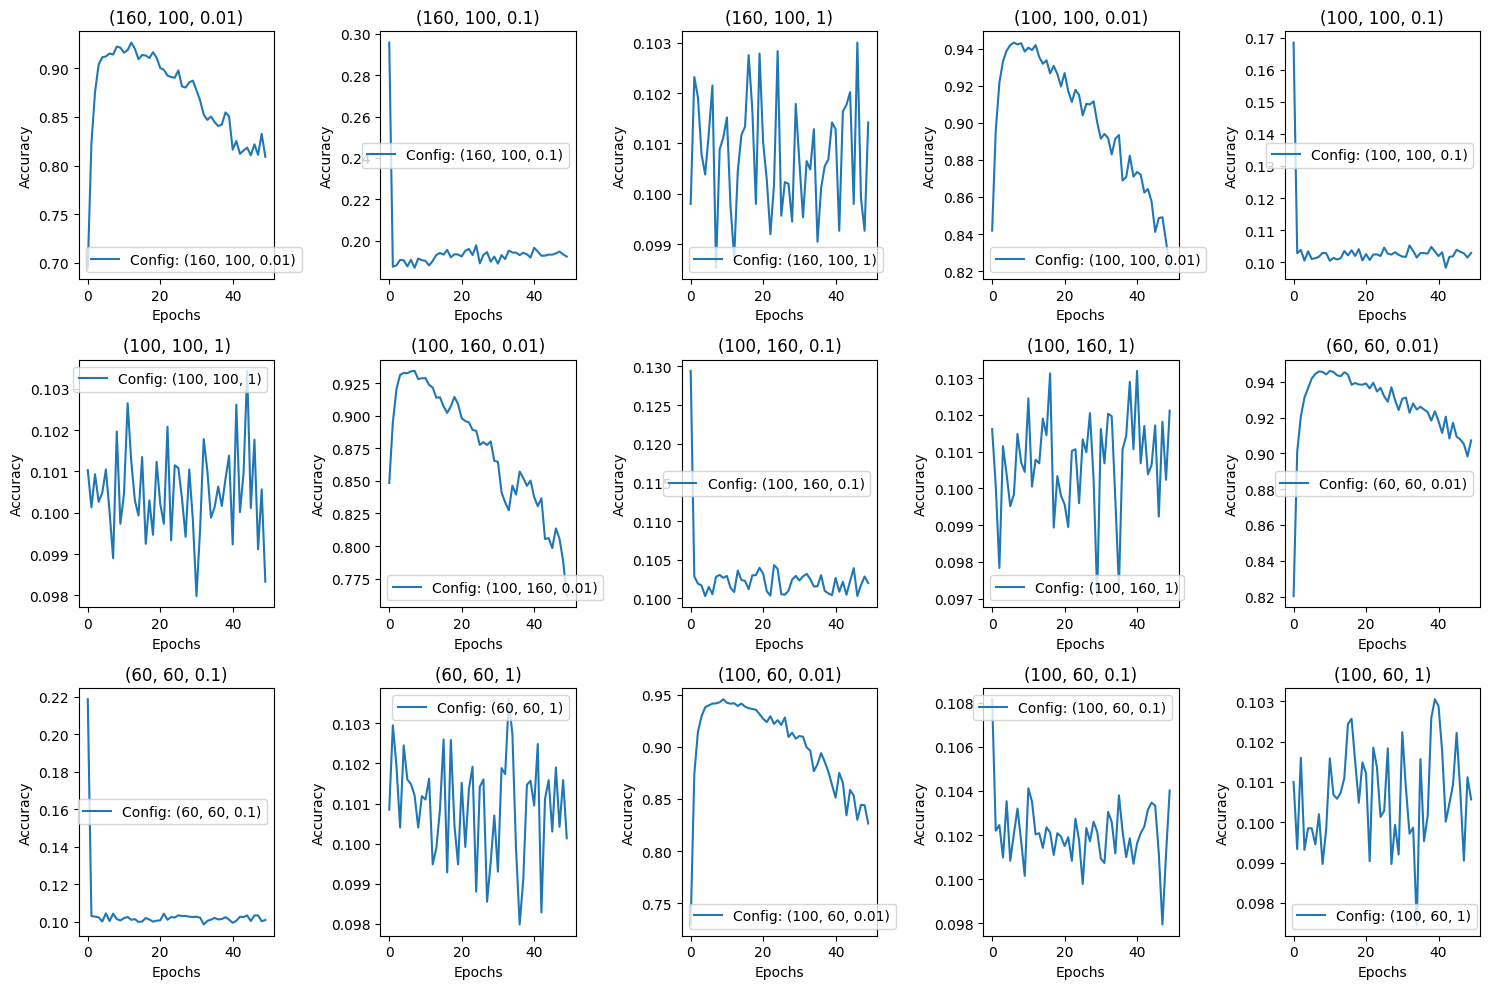

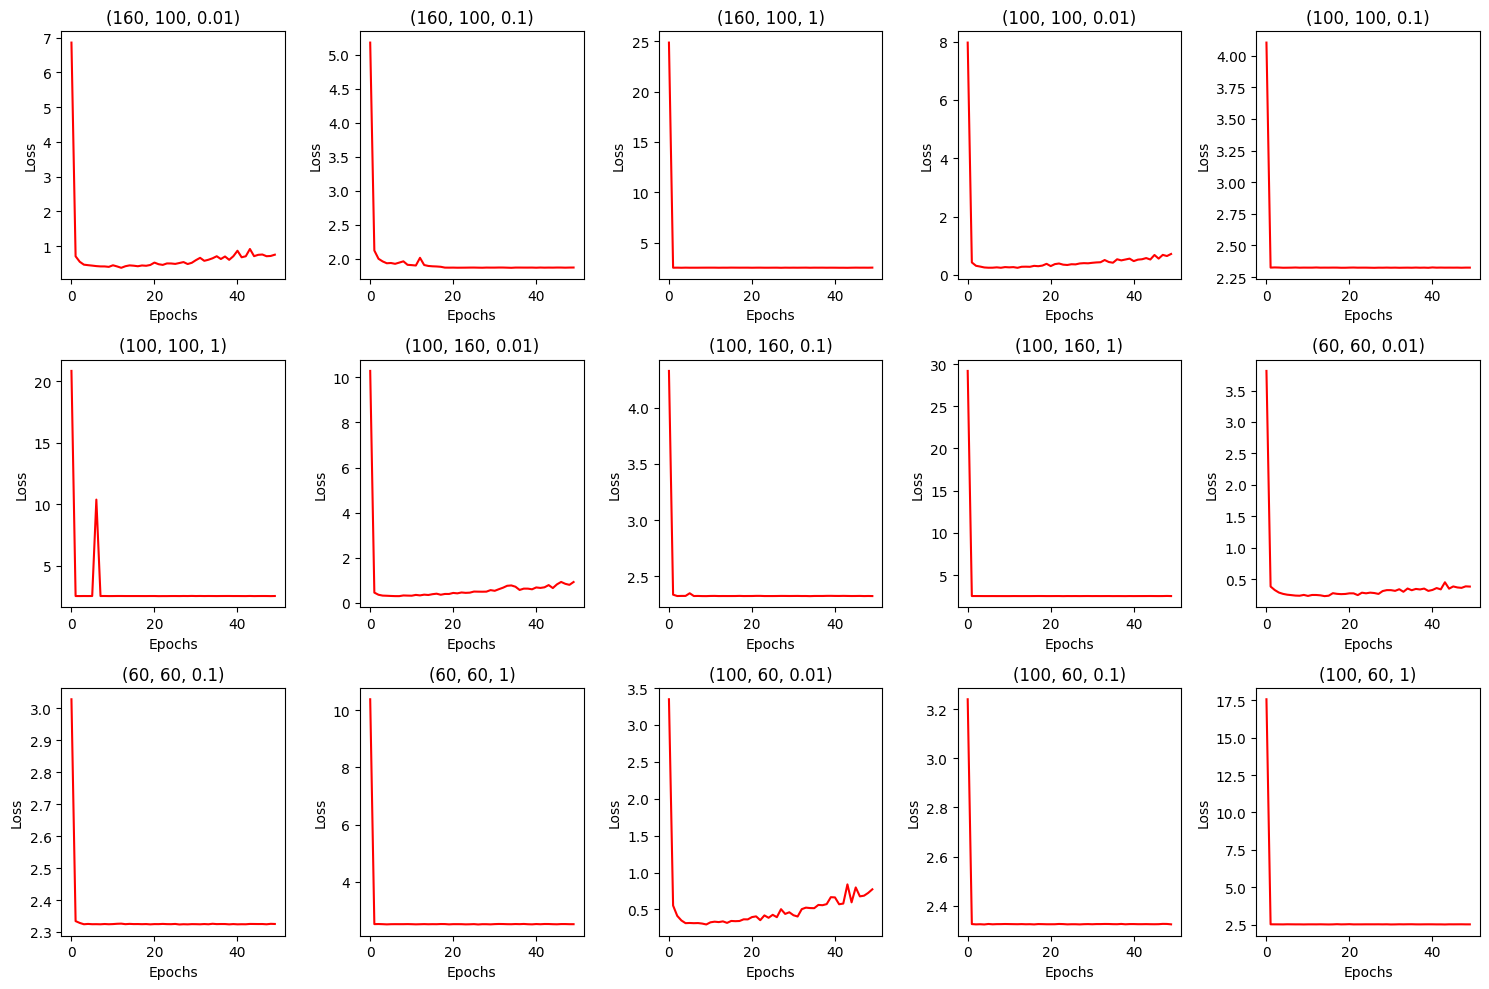

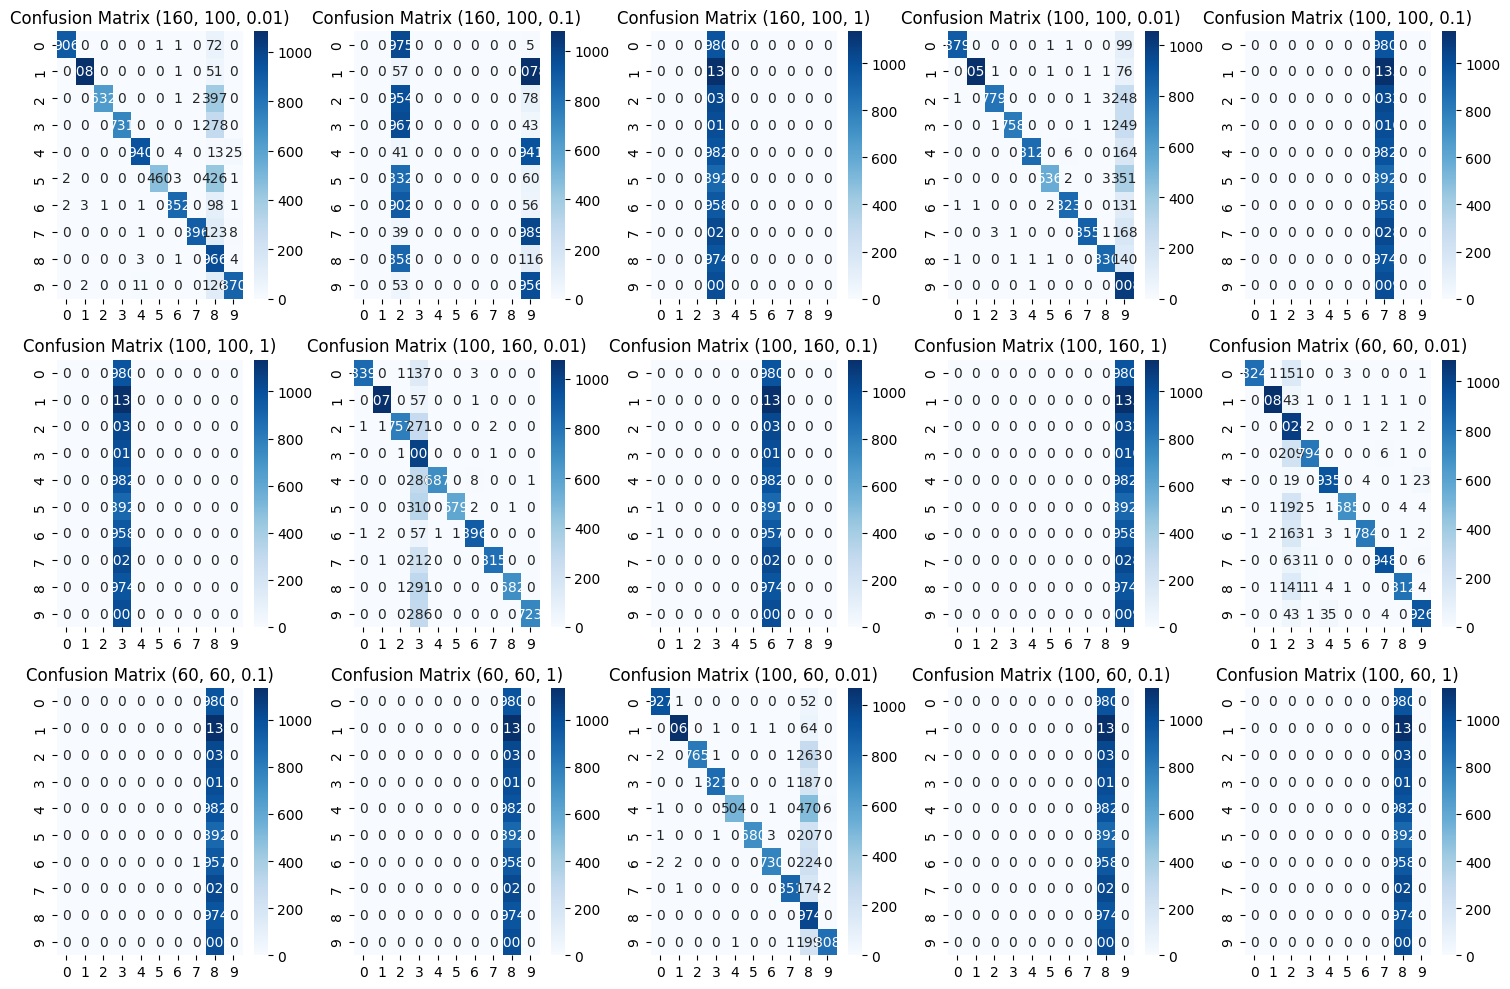

  Hidden Layers  Learning Rate  Test Accuracy  Training Time(sec)
0      [60, 60]           0.01      88.189999          926.422283
1      [60, 60]           0.10       9.740000          967.274757
2      [60, 60]           1.00       9.740000          926.190628
3     [100, 60]           0.01      81.280000          834.430143
4     [100, 60]           0.10       9.740000          922.104976
5     [100, 60]           1.00       9.740000          851.132626


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json


# Load results JSON
results = []  # Ensure results is initialized before appending
with open(base_path + "results_final1.json", "r") as f:
    results += json.load(f)

# Convert results to DataFrame
df = pd.DataFrame(results, columns=["Hidden Layers", "Learning Rate", "Test Accuracy", "Training Time(sec)"])
print(df)

# Load saved results from .npy files
accuracy_curves = np.load(base_path + "accuracy_curves_final1.npy", allow_pickle=True).item()
loss_curves = np.load(base_path + "loss_curves_final1.npy", allow_pickle=True).item()
confusion_matrices = np.load(base_path + "confusion_matrices_final1.npy", allow_pickle=True).item()

# Plot Accuracy Curves
plt.figure(figsize=(15, 10))
for i, key in enumerate(accuracy_curves.keys()):
    plt.subplot(3, 5, i + 1)
    plt.plot(accuracy_curves[key], label=f"Config: {key}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{key}")
    plt.legend()
plt.tight_layout()
plt.show()

# Plot Loss Curves
plt.figure(figsize=(15, 10))
for i, key in enumerate(loss_curves.keys()):
    plt.subplot(3, 5, i + 1)
    plt.plot(loss_curves[key], label=f"Config: {key}", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{key}")
plt.tight_layout()
plt.show()

# Plot Confusion Matrices
plt.figure(figsize=(15, 10))
for i, key in enumerate(confusion_matrices.keys()):
    plt.subplot(3, 5, i + 1)
    sns.heatmap(confusion_matrices[key], annot=True, cmap="Blues", fmt='d')
    plt.title(f"Confusion Matrix {key}")
plt.tight_layout()
plt.show()

# Display Test Accuracy & Training Time in Tabular Format
df = pd.DataFrame(results, columns=["Hidden Layers", "Learning Rate", "Test Accuracy", "Training Time(sec)"])
print(df)


In [21]:

import pandas as pd

df = pd.DataFrame(results, columns=["Hidden Layers", "Learning Rate", "Test Accuracy", "Training Time(sec)"])
print(df)
     

  Hidden Layers  Learning Rate  Test Accuracy  Training Time(sec)
0      [60, 60]           0.01      88.189999          926.422283
1      [60, 60]           0.10       9.740000          967.274757
2      [60, 60]           1.00       9.740000          926.190628
3     [100, 60]           0.01      81.280000          834.430143
4     [100, 60]           0.10       9.740000          922.104976
5     [100, 60]           1.00       9.740000          851.132626


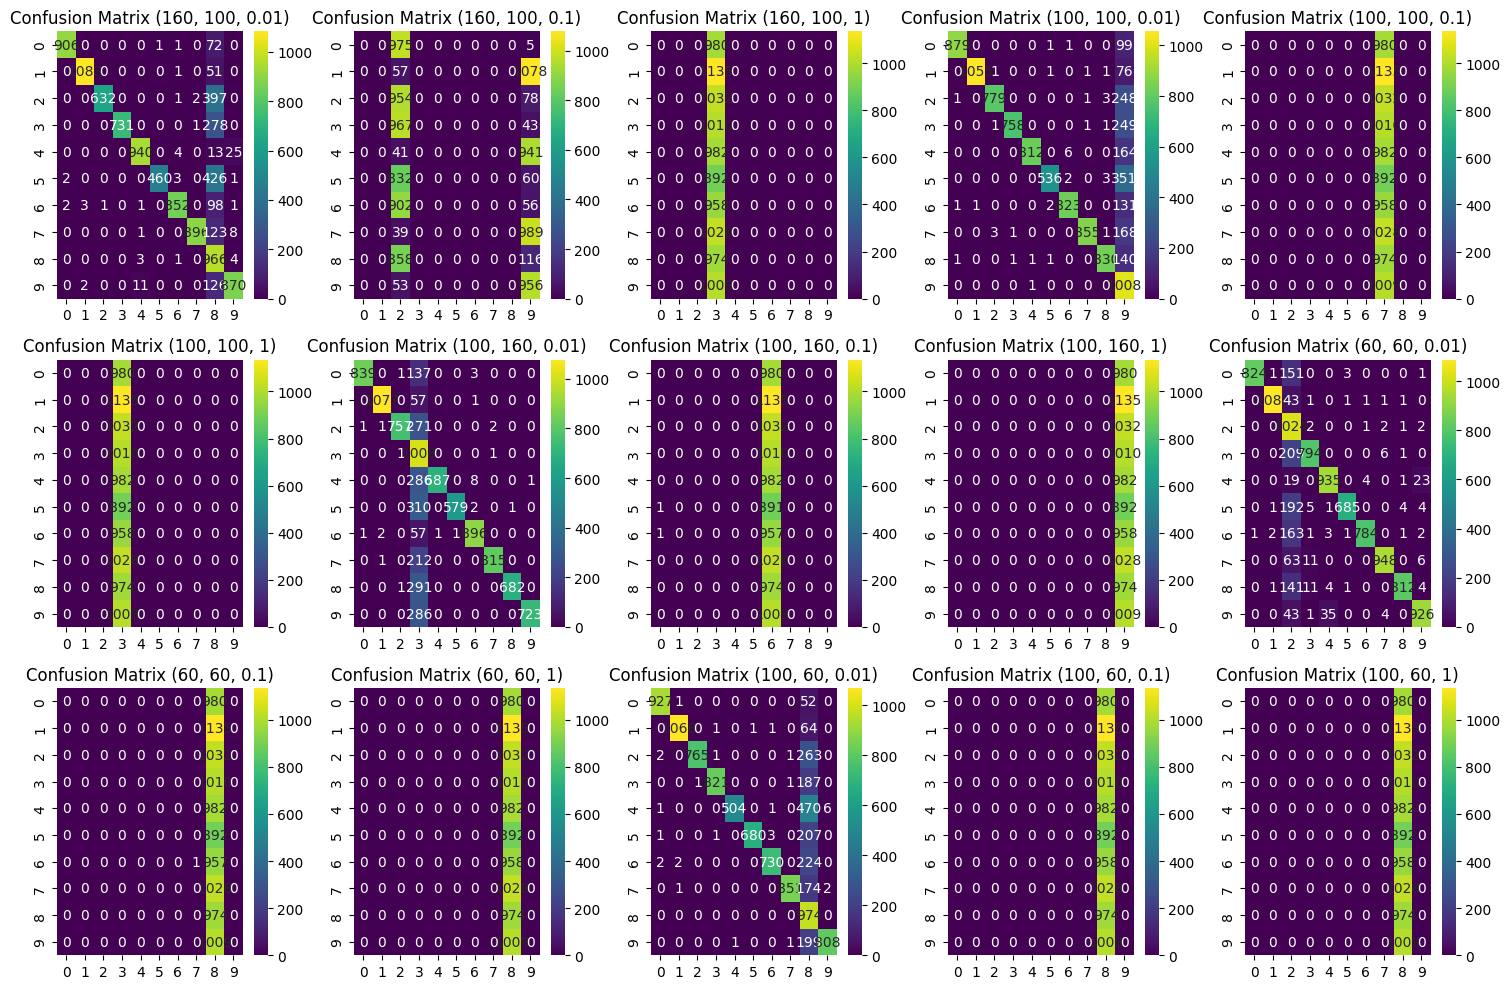

In [22]:

# Plot Confusion Matrices
plt.figure(figsize=(15, 10))
for i, key in enumerate(confusion_matrices.keys()):
    plt.subplot(3, 5, i + 1)
    sns.heatmap(confusion_matrices[key], annot=True, cmap="viridis", fmt='d')
    plt.title(f"Confusion Matrix {key}")
plt.tight_layout()
plt.show()

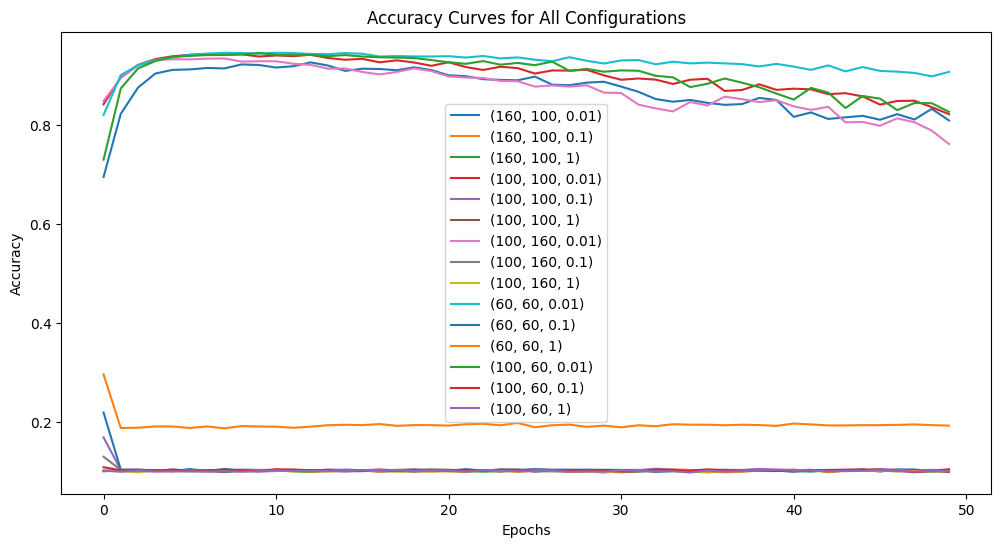

In [23]:

plt.figure(figsize=(12, 6))
for key, values in accuracy_curves.items():
    plt.plot(values, label=f"{key}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves for All Configurations")
plt.legend()
plt.show()